# Create frequent public transport stops analysis - Phoenix, Arizona


This notebook describes a process to retain public transit stops points with frequent service using two methods.

## Method 2: Stop headway analysis using average frequencies of departure

- group by service date, then count the frequencies of departure for each stop
- calculate the average headway during the timeframe over departure
- approach taken by Carl Higgs (20200106) following [tidytransit](http://tidytransit.r-transit.org/articles/servicepatterns.html)



### Notes:

- Input data format, including which tables, which columns, which order and handling of nulls - you'll need to customise this for each city.  A handy guide to the format of GTFS fields is [here](https://developers.google.com/transit/gtfs/reference/#tripstxt).

- GTFS feeds sourced in same season (?) and school term
    - we have vastly different climates across our cities --- so should perhaps aim for Spring? if we chose arbitrary feeds, some in winter and some in summer, our different cities could have vastly different conditions (particularly the snowy ones)
- Week days (Monday to Friday)
    - Day time (7am to 7pm (peak hour: 7am to 9am); as travel during day is important for different segments of community)
 
- We may need to consider details of how headway is operationalised (ie. spot checks do the results look reasonable, and if not how do we deal with it?  this is why I took the maximum headway of the two directions as it at the time seemed a simple and reasonable approach to recognise that a stop need only be frequently serviced in one direction - which is not literally interpreted as 'direction on the road', its do with the route itself.  There may be other methods to consider.)

Previous working branch:

https://github.com/shiqin-liu/global-indicators/blob/phoenix/process/07_create_frequent_public_transport.ipynb  
https://github.com/shiqin-liu/global-indicators/blob/f86f4c2ca068a61f9f2621351f1ce9bbf4b04d88/process/07_create_public_transport_points.ipynb

In [1]:
#conda install -c udst urbanaccess
#For UrbanAccess installation instructions see: https://udst.github.io/urbanaccess/installation.html

In [2]:
#conda install geopandas=0.6.3 -c conda-forge


In [3]:
import pandas as pd
import pandana as pdna
import geopandas as gpd
import os
import time   
import networkx as nx
import osmnx as ox
import numpy as np
import matplotlib.pyplot as plt

import calendar
import datetime

import urbanaccess as ua
from urbanaccess.config import settings
from urbanaccess.gtfsfeeds import feeds
from urbanaccess import gtfsfeeds
from urbanaccess.gtfs.gtfsfeeds_dataframe import gtfsfeeds_dfs

import ua_load


from shapely.geometry import shape,Point, LineString, Polygon

%matplotlib inline


In [4]:
gpd.__version__ # UrbanAccess required earlier version of geopandas


'0.6.3'

In [5]:
# Pandana currently uses depreciated parameters in matplotlib, this hides the warning until its fixed
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


In [6]:
#get lat lon bounding box for each study region
for layer in ['Buffered Adelaide', 'Buffered Melbourne', 'Buffered Sydney']:
    crs = 'epsg:7845'
    # load shapefile
    shape = gpd.GeoDataFrame.from_file('data/Transport/Australian stops for reference/gtfs_2020_02_14_headway_au_global_indicators.gpkg', 
                  layer=layer)
    # create buffer
    polygon = shape['geometry'].iloc[0]
    polygon_proj = ox.project_geometry(polygon, crs=crs, to_crs=None, to_latlong=True)
    # get bounding box
    bbox = polygon_proj[0].bounds
    print(layer, ' : ', bbox)
    
#minx , miny , maxx , maxy

Buffered Adelaide  :  (138.46098212857206, -35.15966609024628, 138.74830806651352, -34.71454282915053)
Buffered Melbourne  :  (144.59067957842007, -38.21131973169178, 145.39847326519424, -37.61837232908795)
Buffered Sydney  :  (150.6290606117829, -34.12321411958463, 151.3206735172292, -33.66275213092711)


In [7]:
# set up study region GTFS config
GTFS = {
        'adelaide':{'gtfs_filename':'data/Transport/2019/gtfs_au_sa_adelaidemetro_20191004',
                    'gtfs_provider' : 'Adelaide Metro',
                    'gtfs_year' : '2019',
                    # define month and day for "representative period" ie. not in school time
                    'start_date_mmdd' : '20191008', 
                    'end_date_mmdd' : '20191205',
                    # get bounding box from study region boundary shapefile
                    # bounding box formatted as a 4 element tuple: (lng_max, lat_min, lng_min, lat_max)
                    # you can generate a bounding box by going to http://boundingbox.klokantech.com/ and selecting the CSV format.
                    'bbox' : (138.46098212857206, -35.15966609024628, 138.74830806651352, -34.71454282915053), 
                    # define modes for GTFS feed(s) as per agency_id codes in agency.txt below
                    'modes' : {
                        'tram':{'route_types': [0], 
                                'peak_hour' : ['07:00:00', '09:00:00'],
                                'day_hour' : ['07:00:00', '19:00:00'],
                                'intervals': 30,
                                'agency_id': None},
                        'bus' : {'route_types': [3],
                                  'peak_hour' : ['07:00:00', '09:00:00'], 
                                  'day_hour' : ['07:00:00', '19:00:00'],
                                  'intervals': 30,
                                 'agency_id': None}
                    }
                   },
        'melbourne':{'gtfs_filename':'data/Transport/2019/gtfs_au_vic_ptv_20191004',
                    'gtfs_provider' : 'Public Transport Victoria',
                    'gtfs_year' : '2019',
                    # define month and day for "representative period" ie. not in school time
                    'start_date_mmdd' : '20191008', 
                    'end_date_mmdd' : '20191205',
                     'bbox' : (144.59067957842007, -38.21131973169178, 145.39847326519424, -37.61837232908795),
                    # define modes for GTFS feed(s) as per agency_id codes in agency.txt below
                    'modes' : {
                        'tram':{'route_types': [0], 
                                'peak_hour' : ['07:00:00', '09:00:00'],
                                'day_hour' : ['07:00:00', '19:00:00'],
                                'intervals': 30,
                                'agency_id': [3]},
                        'bus' : {'route_types': [3],
                                  'peak_hour' : ['07:00:00', '09:00:00'], 
                                  'day_hour' : ['07:00:00', '19:00:00'],
                                  'intervals': 30,
                                 'agency_id': [4, 6]}
                    }
                   },
        'sydney' : {'gtfs_filename':'data/Transport/2019/gtfs_au_nsw_tfnsw_complete_20190619',
                    'gtfs_provider' : 'Transport for NSW',
                    'gtfs_year' : '2019',
                    # define month and day for "representative period" ie. not in school time
                    'start_date_mmdd' : '20191008', 
                    'end_date_mmdd' : '20191205',
                    'bbox' : (150.6290606117829, -34.12321411958463, 151.3206735172292, -33.66275213092711),
                    # define modes for GTFS feed(s) as per agency_id codes in agency.txt below
                    'modes' : {
                        'tram':{'route_types': [0], 
                                'peak_hour' : ['07:00:00', '09:00:00'],
                                'day_hour' : ['07:00:00', '19:00:00'],
                                'intervals': 30,
                                'agency_id': None},
                        'bus' : {'route_types': [700,712,714],
                                  'peak_hour' : ['07:00:00', '09:00:00'], 
                                  'day_hour' : ['07:00:00', '19:00:00'],
                                  'intervals': 30,
                                'agency_id': None}
                    }
                   }
       }
                    



In [8]:
# set up a study region config to run in this notebook
gtfsfeed_path = GTFS['adelaide']['gtfs_filename']
start_date=GTFS['adelaide']['start_date_mmdd']
end_date=GTFS['adelaide']['end_date_mmdd']

peak_hour = GTFS['adelaide']['modes']['bus']['peak_hour']
start_hour = peak_hour[0]
end_hour = peak_hour[1]

headway_intervals = GTFS['adelaide']['modes']['bus']['intervals']
route_types = GTFS['adelaide']['modes']['bus']['route_types']
agency_ids = GTFS['adelaide']['modes']['bus']['agency_id']

shape_layer_name = 'Buffered Adelaide'


# Load GTFS data into an UrbanAccess transit data frame

### Using UrbanAccess as source for:
- The settings object
- The feeds object and searching for GTFS feeds
- Downloading GTFS data
- Loading GTFS data into a UrbanAccess transit data object
- conduct heaway analysis using maxi interdeparture time method


In [9]:
# revise based on origional function, take away the add agency and route type features
loaded_feeds = ua_load.gtfsfeed_to_df(gtfsfeed_path=gtfsfeed_path)

--------------------------------
GTFS text file header whitespace check completed. Took 3.02 seconds
--------------------------------
Processing GTFS feed: gtfs_au_sa_adelaidemetro_20191004
Successfully converted ['departure_time'] to seconds past midnight and appended new columns to stop_times. Took 3.62 seconds
1 GTFS feed file(s) successfully read as dataframes:
     gtfs_au_sa_adelaidemetro_20191004
     Took 8.80 seconds


### The transit data object

The output is a global `urbanaccess_gtfs_df` object that can be accessed with the specified variable `loaded_feeds`. This object holds all the individual GTFS feed files aggregated together with each GTFS feed file type in separate Pandas DataFrames to represent all the loaded transit feeds in a metropolitan area. 

Quickly view the transit stop locations

In [10]:
#loaded_feeds.stops.plot(kind='scatter', x='stop_lon', y='stop_lat', s=0.1)


# Calculate stop level headways
- Calculate headways for the AM Peak time period 
- the original UrbanAccess function calculates the stop and route level headway, it was revised to conduct only the stop level headway analysis.
Check here for the original [function](https://github.com/UDST/urbanaccess/blob/9c0f64faf63bae6f5a73ae23409ca68b28113026/urbanaccess/gtfs/network.py#L192)

In [ ]:
"""hold this condition 
#select daytime bus service
loaded_feeds.stop_times = loaded_feeds.stop_times.sort_values(['trip_id', 'stop_sequence'])
loaded_feeds.stop_times = loaded_feeds.stop_times[(loaded_feeds.stop_times['departure_time'] >= '07:00:00') 
                                                  & (loaded_feeds.stop_times['departure_time'] <= '19:00:00')]

# select stops with ealiest service before 7:30am, and lastest stop before 18:30pm. groupby stop id
stop_first_peak_service_bus = (loaded_feeds.stop_times.groupby(loaded_feeds.stop_times.stop_id).departure_time.min() <= '07:30:00')
stop_last_peak_service_bus = (loaded_feeds.stop_times.groupby(loaded_feeds.stop_times.stop_id).departure_time.max() >= '18:30:00')


loaded_feeds.stop_times = loaded_feeds.stop_times.set_index('stop_id') #set stop_id as index columns
loaded_feeds.stop_times = loaded_feeds.stop_times[(stop_first_peak_service_bus) & (stop_last_peak_service_bus)].reset_index()
"""

## Setup calender

- select valid service id based on weekdays, and start and end date
- this process is developed based on tidytransit [set_date_service_table](https://github.com/r-transit/tidytransit/blob/8a207aaf81482c268aa4bfc548c0697e24b5281c/R/time.R#L59) function

In [12]:
def get_date_weekday_df(start, end):
    """create table to show date and weekday of all dates from start to end date"""
    date_range = pd.date_range(start=start, end=end)
    dates = pd.DataFrame(date_range, columns=['date'])
    # Return the day of the week as an integer, where Monday is 0 and Sunday is 6.
    weekdays = pd.DataFrame(date_range.weekday, columns=['weekday'])
    date_weekday_df = dates.join(weekdays)
    
    # replace weekday numeric to str values
    weekdays = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
    date_weekday_df = date_weekday_df.replace([0, 1, 2, 3, 4, 5, 6], weekdays)
    return date_weekday_df


In [13]:
def set_date_service_table(loaded_feeds):
    """
    Summarize service that run on each date; 
    Use it to summarise service. For example, get a count of the number of services for a date.
    """
    # tabulate each date and weekday from the start to the end date in calendar  
    dates = get_date_weekday_df(start=str(min(loaded_feeds.calendar['start_date'])), 
                            end=str(max(loaded_feeds.calendar['end_date'])))
    
    # gather services by weekdays
    service_ids_weekdays = loaded_feeds.calendar[['service_id', 'start_date', 'end_date', 
                           'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday'
                          ]].set_index(['service_id', 'start_date', 'end_date'
                                       ]).stack().to_frame().reset_index()

    service_ids_weekdays = service_ids_weekdays[(service_ids_weekdays[0] == 1)
                                               ].rename(columns={'level_3':'weekday'}).drop(columns=[0])
    # create table to connect every date to corresponding services (all dates from earliest to latest)
    # set services to dates according to weekdays and start/end date
    date_service_df = pd.merge(dates, service_ids_weekdays, on='weekday')

    date_service_df['start_date'] = pd.to_datetime(date_service_df['start_date'], format='%Y%m%d')
    date_service_df['end_date'] = pd.to_datetime(date_service_df['end_date'], format='%Y%m%d')


    #filter valid service date within start and end date
    date_service_df = date_service_df[(date_service_df['date'] >= date_service_df['start_date']) 
                    & (date_service_df['date'] <= date_service_df['end_date'])][['date', 'weekday', 'service_id']]
    
    
    # add calendar_dates additions (1) if the additional dates are within the start and end date range
    addition_dates = loaded_feeds.calendar_dates[(loaded_feeds.calendar_dates['exception_type']==1)
                                                ][['service_id', 'date']]

    min_start_datetime = pd.to_datetime(str(min(loaded_feeds.calendar['start_date'])), format='%Y%m%d')
    max_end_datetime = pd.to_datetime(str(max(loaded_feeds.calendar['end_date'])), format='%Y%m%d')
    addition_dates['date'] = pd.to_datetime(addition_dates['date'], format='%Y%m%d')

    addition_dates['within_range'] = addition_dates['date'].apply(
        lambda x: 1 if (x >= min_start_datetime
                       ) & (x <= max_end_datetime) else 0)

    addition_dates = addition_dates[addition_dates['within_range'] == 1][['service_id', 'date']]
    date_service_df = pd.concat([addition_dates, date_service_df], ignore_index=True)
    
    # remove calendar_dates exceptions (2)
    exception_dates = loaded_feeds.calendar_dates[(loaded_feeds.calendar_dates['exception_type']==2)
                                                 ][['service_id', 'date']]

    exception_dates['date'] = pd.to_datetime(exception_dates['date'], format='%Y%m%d')

    date_service_exception_df = pd.merge(exception_dates.set_index(['service_id', 'date']
                                      ), date_service_df.set_index(['service_id', 'date']), 
             left_index=True, right_index=True, indicator=True, how='outer').reset_index()

    date_service_df = date_service_exception_df[(date_service_exception_df['_merge']=='right_only')
                                               ][['service_id', 'date', 'weekday']]
    return date_service_df
    
   

# Stop headway analysis using average departure time within the timeframe

- Identify feeds start and end dates that that a stop is a 30-minute frequency stop  
- group by service date, then count the frequencies of departure for each stop
- calculate the average headway during the timeframe over departure
- approach taken by Carl Higgs (20200106) following [tidytransit](http://tidytransit.r-transit.org/articles/servicepatterns.html)

In [14]:
# revise based on tidytransit [get_stop_frequency function]
# https://github.com/r-transit/tidytransit/blob/master/R/frequencies.R

def get_hlc_stop_frequency(loaded_feeds, start_hour, end_hour, start_date, 
                           end_date, route_types, agency_ids, 
                           dow=['monday','tuesday','wednesday','thursday','friday']):
    startTime = time.time()
    # set service date
    date_service_df = set_date_service_table(loaded_feeds)

    # limit within specified start and end date, and within weekdays
    start_date_mmdd = pd.to_datetime(start_date, format='%Y%m%d')
    end_date_mmdd = pd.to_datetime(end_date, format='%Y%m%d')

    date_service_df = date_service_df[date_service_df['weekday'].isin(dow)
                                     ][(date_service_df['date'] >= start_date_mmdd) 
                                       & (date_service_df['date'] <= end_date_mmdd)].drop_duplicates()
    print('     ', len(date_service_df), ' unique service dates are identified within', 
          dow, ' from ', start_date, ' to ', end_date)
    
    
    trips_routes = pd.merge(loaded_feeds.trips, loaded_feeds.routes, on='route_id', how='left')
    # filter route trips based on valid services
    valid_service_ids = date_service_df.service_id.unique()
    trips_routes = trips_routes[trips_routes['service_id'].isin(valid_service_ids)]
    
    # filter trips within route types and agency id
    if (route_types != None) & (agency_ids == None):
        trips_routes = trips_routes[(trips_routes['route_type'].isin(route_types))]
        date_service_df = date_service_df[date_service_df['service_id'].isin(trips_routes.service_id.unique())]
    elif (route_types != None) & (agency_ids != None):
        trips_routes = trips_routes[(trips_routes['agency_id'].isin(agency_ids)) & (trips_routes['route_type'].isin(route_types))]
        date_service_df = date_service_df[date_service_df['service_id'].isin(trips_routes.service_id.unique())]
    elif (route_types == None) & (agency_ids != None):
        trips_routes = trips_routes[(trips_routes['agency_id'].isin(agency_ids))]
        date_service_df = date_service_df[date_service_df['service_id'].isin(trips_routes.service_id.unique())]
        
    # takes input start and end time range from 24 hour clock and converts
    # it to seconds past midnight
    # in order to select times that may be after midnight

    # convert string time components to integer and then calculate seconds
    # past midnight
    # convert starttime 24 hour to seconds past midnight
    start_h = int(str(start_hour[0:2]))
    start_m = int(str(start_hour[3:5]))
    start_s = int(str(start_hour[6:8]))
    starttime_sec = (start_h * 60 * 60) + (start_m * 60) + start_s

    # convert endtime 24 hour to seconds past midnight
    end_h = int(str(end_hour[0:2]))
    end_m = int(str(end_hour[3:5]))
    end_s = int(str(end_hour[6:8]))
    endtime_sec = (end_h * 60 * 60) + (end_m * 60) + end_s

    stop_times = loaded_feeds.stop_times[loaded_feeds.stop_times.trip_id.isin(trips_routes.trip_id.unique())]

    # filter stop times within the timerange
    selected_stop_times_df = stop_times[((starttime_sec < loaded_feeds.stop_times[
        'departure_time_sec'])  & (stop_times["departure_time_sec"] < endtime_sec))]
    
    # filter valid service trips
    valid_service_trips = pd.merge(date_service_df, trips_routes, on='service_id', how='left')

    # filter stops within valid service and time range 
    stop_time_trips = pd.merge(valid_service_trips, selected_stop_times_df, on='trip_id', how='inner')
    
    # group by service date to get counts of departure of each stop of each direction
    stop_time_trips_departure = stop_time_trips[['direction_id', 'stop_id', 'date', 'service_id'
                                      ]].groupby(['direction_id', 'stop_id', 'date']).agg(['count'])

    stop_time_trips_departure.columns = ['departure']
    
    # count sec. and min. within the timerange
    t1_min = (endtime_sec - starttime_sec)/60
    
    # for each stop we average headway over dates 
    # We take the best (smallest) headway out of the two possible of the stop
    # this is because many stops have frequent service in one direction 
    # and infrequent in the other (ie. inbound vs outbound differences)
    stop_time_trips_departure['headway'] = round(t1_min / stop_time_trips_departure['departure'])
    
    stops_headway = stop_time_trips_departure.reset_index().groupby([
    'stop_id', 'direction_id']).mean().groupby('stop_id').min()[['headway']]
    
    #print('     Time to complete average stop headway analysis with {} frequent stops is: {}'.format(len(stops_headway), time.time() - startTime))
    
    return stops_headway
    


In [15]:
stops_headway = get_hlc_stop_frequency(loaded_feeds, start_hour, end_hour, start_date, 
                           end_date, route_types, agency_ids, 
                           dow=['monday','tuesday','wednesday','thursday','friday'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


      1258  unique service dates are identified within ['monday', 'tuesday', 'wednesday', 'thursday', 'friday']  from  20191008  to  20191205


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [25]:
# select average departure headway less than or equal to maxi headway frequency intervals
stop_30_mins_headway = stops_headway[stops_headway['headway'] <= 20]

# get spatial features for freqent stops
stop_30_mins_final = pd.merge(stop_30_mins_headway, loaded_feeds.stops, how='left', on='stop_id')

# add stop id geometry
stop_30_mins_final['geometry'] = stop_30_mins_final.apply(
    lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)
stop_30_mins_final = gpd.GeoDataFrame(stop_30_mins_final)

In [26]:
len(stop_30_mins_final)

3894

In [27]:
len(loaded_feeds.stops.drop_duplicates(subset='stop_id'))

7746

# Plot bus stop and freqent bus stop

In [28]:
# get the study region boundary gdf
shape = gpd.GeoDataFrame.from_file('data/Transport/Australian stops for reference/gtfs_2020_02_14_headway_au_global_indicators.gpkg', 
                  layer=shape_layer_name)

polygon = shape['geometry'].iloc[0]
crs = shape.crs['init']

polygon_proj = ox.project_geometry(polygon, crs=crs, to_crs=None, to_latlong=True)
shape_proj = gpd.GeoDataFrame(polygon_proj[0]).rename(columns={0:'geometry'})
shape_proj = gpd.GeoDataFrame(shape_proj,  geometry='geometry')

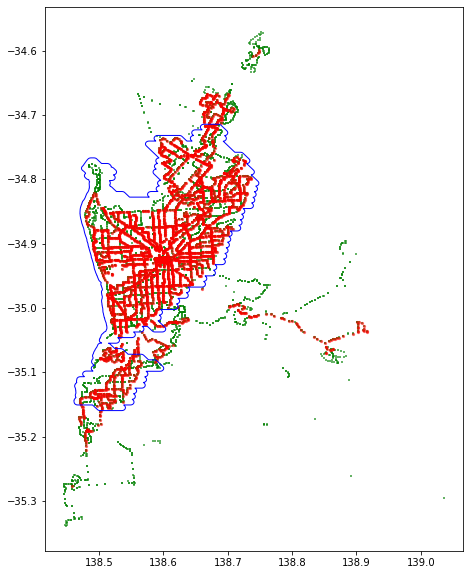

In [29]:
# set spatial geometry for all stops 
loaded_feeds.stops['geometry'] = loaded_feeds.stops.apply(
    lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)
all_stops_gdf = gpd.GeoDataFrame(loaded_feeds.stops)

# plot the stops
fig, ax = plt.subplots(figsize=(10, 10))
ax = all_stops_gdf.plot(ax=ax, color='green', marker='+', markersize=5, alpha=0.6)
ax = stop_30_mins_final.plot(ax=ax, color='red', marker='o', markersize=5, alpha=0.5)
ax = shape_proj.plot(ax=ax, color='none', edgecolor='blue')

#ax.set_axis_off()

plt.show()

In [31]:
# select stops within study region boundary
len(stop_30_mins_final[(stop_30_mins_final.within(polygon_proj[0]))])

3526

In [32]:
# all stops within study region boundary
len(all_stops_gdf[(all_stops_gdf.within(polygon_proj[0]))])

6198

# Run all cities GTFS frequent stop analysis
TODO: move to a python script

In [ ]:
# get the work directory
dirname = os.path.abspath('') 

# geopackage path where to save processing layers
gpkgPath_output = os.path.join(dirname, 'data/Transport', 'frequent_transit_headway_2020April_python.gpkg')


for city in GTFS.keys():
    #print(city)
    city_config = GTFS['{}'.format(city)]
    gtfsfeed_path = city_config['gtfs_filename']
    start_date = city_config['start_date_mmdd']
    end_date = city_config['end_date_mmdd']
    authority = city_config['gtfs_provider']
    
    loaded_feeds = ua_load.gtfsfeed_to_df(gtfsfeed_path=gtfsfeed_path)
    
    for hour in ['peak_hour']:
        #print(hour)
        stop_frequent = pd.DataFrame()
        
        
        for mode in ['tram', 'bus']:
            startTime = time.time()
            print('Start to process {} {} analysis during {}'.format(city, mode, hour))
            
            hour_1 = city_config['modes']['{}'.format(mode)]['{}'.format(hour)]
            start_hour = hour_1[0]
            end_hour = hour_1[1]

            headway_intervals = city_config['modes']['{}'.format(mode)]['intervals']
            route_types = city_config['modes']['{}'.format(mode)]['route_types']
            agency_ids = city_config['modes']['{}'.format(mode)]['agency_id']
            
            stops_headway = get_hlc_stop_frequency(loaded_feeds, start_hour, end_hour, start_date, 
                               end_date, route_types, agency_ids, 
                               dow=['monday','tuesday','wednesday','thursday','friday'])

            # select average departure headway less than or equal to maxi headway frequency intervals
            #stop_frequent_headway = stops_headway[stops_headway['headway'] <= headway_intervals]
            
            if len(stops_headway) > 0:
                stop_frequent_final = pd.merge(stops_headway, loaded_feeds.stops, how='left', on='stop_id')
                stop_frequent_final['authority'] = authority
                stop_frequent_final['mode'] = mode
                stop_frequent = stop_frequent.append(stop_frequent_final)
                print('     Complete {} ({}) {} during {} with {} stop counts in {} seconds'.format(
                    city, authority, mode, hour, len(stops_headway), time.time() - startTime))
            else:
                continue

        # get spatial features for freqent stops
        # add stop id geometry
        stop_frequent['geometry'] = stop_frequent.apply(
            lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)
        stop_frequent_gdf = gpd.GeoDataFrame(stop_frequent)


        # save to output file
        # save the frequent stop by study region and modes to a new layer in geopackage
        stop_frequent_gdf.to_file(
            gpkgPath_output,
            layer='{}_{}min_stops_{}_{}_{}'.format(
                city, headway_intervals, hour, start_date, end_date),
            driver='GPKG')



--------------------------------
GTFS text file header whitespace check completed. Took 5.71 seconds
--------------------------------
Processing GTFS feed: gtfs_au_sa_adelaidemetro_20191004
Successfully converted ['departure_time'] to seconds past midnight and appended new columns to stop_times. Took 4.33 seconds
1 GTFS feed file(s) successfully read as dataframes:
     gtfs_au_sa_adelaidemetro_20191004
     Took 17.42 seconds
Start to process adelaide tram analysis during peak_hour
      1258  unique service dates are identified within ['monday', 'tuesday', 'wednesday', 'thursday', 'friday']  from  20191008  to  20191205


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


     Complete adelaide (Adelaide Metro) tram during peak_hour with 62 stop counts in 0.8047759532928467 seconds
Start to process adelaide bus analysis during peak_hour
      1258  unique service dates are identified within ['monday', 'tuesday', 'wednesday', 'thursday', 'friday']  from  20191008  to  20191205
     Complete adelaide (Adelaide Metro) bus during peak_hour with 7084 stop counts in 5.925052642822266 seconds
--------------------------------
GTFS text file header whitespace check completed. Took 40.29 seconds
--------------------------------
Processing GTFS feed: gtfs_au_vic_ptv_20191004
Successfully converted ['departure_time'] to seconds past midnight and appended new columns to stop_times. Took 19.31 seconds
1 GTFS feed file(s) successfully read as dataframes:
     gtfs_au_vic_ptv_20191004
     Took 69.80 seconds
Start to process melbourne tram analysis during peak_hour
      3170  unique service dates are identified within ['monday', 'tuesday', 'wednesday', 'thursday', 'fr